# Test Run 12 Mini Dataset Exploration w/ Word-level Segments
In this notebook, we implement our switched-decision of using *word* as the segmentation unit. See weekly progress report of 18Fall, week 6 for our argument of using *clause* as the segmentation unit causes many conflict!!! 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not in debug mode, please set debug_mode=0, find more info about debug mode in test run 9 maybe?
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
os.environ['SNORKELDB'] = "postgresql:///abstractnetword"
print(os.environ['SNORKELDB'])

from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor
session = SnorkelSession()

# # Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 100 # this is the upper limit of number of docs
doc_preprocessor = TSVDocPreprocessor('data/slim-s2-corpus-00-1000', encoding="utf-8",max_docs=n_docs)

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)# ,parallelism=5)

from snorkel.models import Document, Sentence  # defined in context.py file

print("Documents:", session.query(Document).count())

postgresql:///abstractnetword
Clearing existing...
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
clearning..
clear finished!
Running UDF...
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
[========================================] 100%

CPU times: user 2.56 s, sys: 126 ms, total: 2.69 s
Wall time: 3.56 s
Documents: 100


In [6]:
from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence

session = SnorkelSession()
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

docs = session.query(Document).all()
sents = session.query(Sentence).all()  # get all sentences from snorkel.db
n_max_corpus=0
for sent in sents:
    n_max_corpus=max(n_max_corpus,len(sent.words))
    if len(sent.words)==180:
        print(sent)
print("The longest sentence has "+str(n_max_corpus)+" tokens.")
train_sents=sents

Documents: 100
Sentences: 685
The longest sentence has 93 tokens.


In [7]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *
import datetime

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Unigram = candidate_subclass('Unigram', ['unigram_cue'],values=['PP','MN','NULL'])
ngrams = Ngrams(n_max=1) 
ngram_matcher=NgramMatcher()
unigram_segment_extractor=CandidateExtractor(Unigram,[ngrams],[ngram_matcher])

%time unigram_segment_extractor.apply(train_sents, split=0)
unigram_segments=session.query(Unigram).filter(Unigram.split == 0).all()
print("len(train_segments)",len(unigram_segments))

Clearing existing...
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
clearning..
Running UDF...
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
[========================================] 100%

CPU times: user 27.1 s, sys: 1.96 s, total: 29 s
Wall time: 59.8 s
len(train_segments) 17110


In [66]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator
from LF.util_common_default_categorical import purpose_LFs,mechanism_LFs,null_LFs
print("total LF count", len(purpose_LFs+mechanism_LFs+null_LFs),"unique ",len(set(purpose_LFs+mechanism_LFs+null_LFs)),"purpose_LFs",len(purpose_LFs),"mechanism_LFs",len(mechanism_LFs))
print([lf.__name__ for lf in mechanism_LFs])

total LF count 80 unique  80 purpose_LFs 31 mechanism_LFs 35
['LF_mechanism_PRP_VBP3_True', 'LF_mechanism_PRP_VBPneg2_True', 'LF_mechanism_PRP_RB_VBP3_True', 'LF_mechanism_PRP_RB_VBPneg2_True', 'LF_mechanism_we_propose3_True', 'LF_mechanism_we_proposeneg2_True', 'LF_mechanism_we_develop3_True', 'LF_mechanism_we_developneg2_True', 'LF_mechanism_we_provide3_True', 'LF_mechanism_we_provideneg2_True', 'LF_mechanism_we_have_developed3_True', 'LF_mechanism_we_have_developedneg2_True', 'LF_mechanism_we_also_propose3_True', 'LF_mechanism_we_also_proposeneg2_True', 'LF_mechanism_presents_3_True', 'LF_mechanism_presents_neg2_True', 'LF_mechanism_present_3_True', 'LF_mechanism_present_neg2_True', 'LF_mechanism_we_use_3_True', 'LF_mechanism_we_use_neg2_True', 'LF_mechanism_uses_3_True', 'LF_mechanism_uses_neg2_True', 'LF_mechanism_using_a_3_True', 'LF_mechanism_using_a_neg2_True', 'LF_mechanism_by_using3_True', 'LF_mechanism_by_usingneg2_True', 'LF_mechanism_method3_True', 'LF_mechanism_methodneg2

In [67]:
from snorkel.learning import GenerativeModel
from util import get_candidate_text
import matplotlib.pyplot as plt
import datetime

# maybe write a cids_query session.query(Candidate.id).filter(Candidate.split == split) from def apply(self, split=0, key_group=0, replace_key_set=True, cids_query=None,
#         **kwargs):
def get_L_train(LFs,parallelism=1,split=0):
    L_train=None
    labeler=None
    np.random.seed(1701)
    labeler = LabelAnnotator(lfs=LFs)
    print(datetime.datetime.now())
    L_train = labeler.apply(split=split,parallelism=parallelism)# ,cids_query=session.query(Candidate.id).filter(Candidate.get_parent().id %10==1))
    print(datetime.datetime.now())
    print(type(L_train))
    print(L_train.shape)
    printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
    return L_train

def get_train_marginals(L_train,step_size_nominator=0.1,epochs=100,threads=1,class_prior=False,decay=1.0,reg_param=1e-6):
    try:
        gen_model=None
        print(datetime.datetime.now())
        gen_model = GenerativeModel(lf_propensity=True,class_prior=class_prior)
#         gen_model.train(L_train, cardinality=3, epochs=100, decay=0.95, step_size=step_size_nominator/L_train.shape[0], reg_param=0.0,verbose=False,threads=threads) # try step_size = 1/ next time? 
        gen_model.train(L_train, cardinality=3, epochs=epochs, decay=decay,step_size=step_size_nominator/1e2,reg_param=reg_param,verbose=False,threads=threads)
        print("training finished ")
        print(datetime.datetime.now())
        print("Finished training generative model, now checking performance against development set labels...")
        print("Calculating marginals!")
        train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
#         assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)
        print("no exception")
        print(datetime.datetime.now())
        return gen_model,train_marginals
    except:
        print("exception! ")
        return gen_model,train_marginals


In [ ]:
L_train=get_L_train(purpose_LFs+mechanism_LFs+null_LFs)

snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
2018-10-10 17:59:11.198681
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
cids_count 17110
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
clearning..
Running UDF...
snorkel_conn_string postgresql:///abstractnetword
if snorkel_postgres? True
[====================                    ] 49%

In [62]:
print(len(purpose_LFs+mechanism_LFs+null_LFs))
print(L_train.shape)

62
(17110, 59)


In [63]:
import pandas as pd 
pd.set_option('display.max_rows', 500)

L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_purpose_TO_VB_neg2_True,0,0.176388,0.147458,0.074401
LF_purpose_that_can3_True,1,0.000701,0.000643,0.000234
LF_purpose_that_canneg2_True,2,0.006604,0.006312,0.001636
LF_purpose_for_the3_True,3,0.003390,0.002981,0.001052
LF_purpose_for_theneg2_True,4,0.024898,0.020573,0.008416
LF_purpose_goal3_True,5,0.001753,0.001403,0.000526
LF_purpose_goalneg2_True,6,0.012098,0.011572,0.004559
LF_purpose_problem3_True,7,0.006487,0.006487,0.001987
LF_purpose_problemneg2_True,8,0.030275,0.025015,0.012274
LF_purpose_challenging3_True,9,0.000877,0.000877,0.000175


In [64]:
# for reg_param in [1e-3]: #[1e-3, 1e-6]:
#     for decay in [0.95]: #[1.0,0.95]:
#         for step_size_nominator in [0.001]: # [0.01, 0.1, 1]:
#             for epochs in [5]: #,10]:#,30,50,100,200,500]:
#                 print("grid search with L_train","step_size_nominator",step_size_nominator,"epochs",epochs,"decay",decay,"reg_param",reg_param)

                
reg_param=1e-3
decay=0.95
step_size_nominator=0.001
epochs=5
                        
gen_model,train_marginals=get_train_marginals(L_train,threads=18,step_size_nominator=step_size_nominator,epochs=epochs,decay=decay,reg_param=reg_param)
assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

winHighlight=train_marginals.argmax(axis=1)
print("PP",(winHighlight==0).sum())
print("MN",(winHighlight==1).sum())
print("NULL",(winHighlight==2).sum())

# Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
train_marginals_reverse = train_marginals[:,::-1]
winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
print("amend PP",(winHighlight==0).sum())
print("amend MN",(winHighlight==1).sum())
print("amend NULL",(winHighlight==2).sum())


2018-10-10 17:41:01.286793
Compiles variable matrix
_compile finished!
Compiles variable matrix
_compile finished!
training finished 
2018-10-10 17:41:41.159811
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
no exception
2018-10-10 17:41:44.366143
PP 11817
MN 4120
NULL 1173
amend PP 4963
amend MN 4120
amend NULL 8027


Let's check if the generative labels makes any sense. -> Seems okay. 

0
10000
dispatch finished!! 


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0
10000
dispatch finished!! 


<Figure size 432x288 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

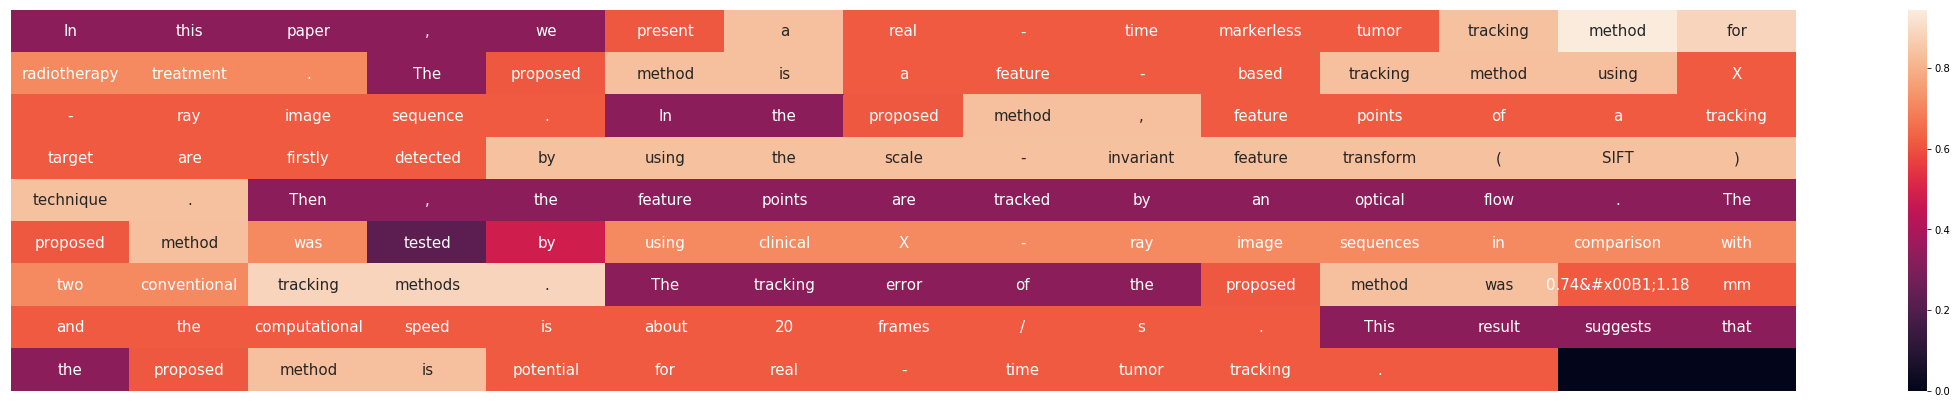

In [65]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os 

def pad_reshape(A,width,isFloat=False):
    B=np.empty([1,int(A.shape[1]/width+1)*width],dtype=object)
    if isFloat:
        B=np.zeros([1,int(A.shape[1]/width+1)*width])
        B[:,:A.shape[1]]=A
    else:
        B[:,:A.shape[1]]=A
        B[:,A.shape[1]:]=""
    return B.reshape(-1,width)
    
def visualize_word_level(tag,unigram_segments,score_list,directory="data/word_level_tag_visualization"):
    doc_dict=defaultdict(lambda:[])

    pair_list=list(zip(unigram_segments,score_list))

    for ind,pair in enumerate(pair_list):
        if ind%10000==0:
            print(ind)
        docid=pair[0].get_parent().get_parent().name
        doc_dict[docid]+=[pair]

    print("dispatch finished!! ")

    for docid in doc_dict:
        plt.clf()
        doc_dict[docid]=sorted(doc_dict[docid], key=lambda pair: (pair[0].get_parent().position, pair[0].get_contexts()[0].get_word_start()))
        ordered_word_score_list=[(pair[0].get_parent().text[pair[0].unigram_cue.char_start:pair[0].unigram_cue.char_end+1], pair[1]) for pair in doc_dict[docid]]
        df=pd.DataFrame.from_records(ordered_word_score_list,columns=['word','score'])
        fig, ax = plt.subplots(figsize=(40,7))  
        width=15
        sns.heatmap(pad_reshape(np.asarray(df[['score']]).reshape(1,-1),width,isFloat=True), annot=pad_reshape(np.asarray(df[['word']]).reshape(1,-1),width),fmt='',yticklabels=False,xticklabels=False,ax=ax,annot_kws={"size": 15})
        plt.savefig(os.path.join(directory,"run",docid+"_"+tag))
  

visualize_word_level("PP",unigram_segments,list(train_marginals[:,0].reshape(-1))) 
visualize_word_level("MN",unigram_segments,list(train_marginals[:,1].reshape(-1)))
    

In [16]:
pair_list=list(zip(unigram_segments,list(train_marginals[:,0].reshape(-1))))

pair_list.sort(key = lambda t: t[1],reverse=True)

def get_candidate_text(candidate):
    cue=candidate.get_contexts()[0]
    return cue.sentence.text[cue.char_start:cue.char_end+1]

top_cutoff=10
print("top purpose words \n\n")
print("\n\n".join([str(ind)+"\tWord\t"+get_candidate_text(pair[0])+"\n"+"Sentence\t"+str(pair[0].get_parent().text)+"\t"+str(pair[1]) for ind,pair in enumerate(pair_list[:top_cutoff])]))


pair_list=list(zip(unigram_segments,list(train_marginals[:,1].reshape(-1))))
pair_list.sort(key = lambda t: t[1],reverse=True)

print("\n\n\ntop mechanism words \n\n")
print("\n\n".join([str(ind)+"\tWord\t"+get_candidate_text(pair[0])+"\n"+"Sentence\t"+str(pair[0].get_parent().text)+"\t"+str(pair[1]) for ind,pair in enumerate(pair_list[:top_cutoff])]))

top purpose words 


0	Word	to
Sentence	In our register allocation method, we construct an extended conflict graph (ECG) whose vertices are variables and the weight of each edge shows the cost of assigning two endpoint variables of the edge to a register.	0.9999999999999898

1	Word	of
Sentence	This paper attempts to lay a firmer foundtion for a theory of these problems.	0.9999999999999851

2	Word	at
Sentence	Taking the midpoint of the untransformed confidence interval as our point estimator of the expected simulation response at the selected factor-level combination and approximating the variance of this point estimator via the delta method, we formulate an approximate two-sample Student <i>t</i>-test for validating our metamodel-based estimator versus the results of making independent runs of the simulation at the selected factor-level combination.	0.9999999999999769

3	Word	in
Sentence	Based on this scenario, this paper proposes an approach with the purpose of supporting the unique o

In [17]:
# TODO get_surrounding_words maybe group segments back to doc level from  Sentence has words in its __dict__ 

# visualize purpose probability


# pair_list=list(zip(unigram_segments,list(train_marginals[:,0].reshape(-1))))

# count=0
# for idx,segment in enumerate(unigram_segments):
#     if "by" in segment.get_parent().__dict__['words']:
#         print(idx,segment.get_parent().__dict__['text'])
#         if count>30:
#             break
#         count+=1
        
from LF.util_common_default_categorical import purpose_LFs,mechanism_LFs

for i in range(288,305):
    print(unigram_segments[i])
    print(unigram_segments[i].get_parent().__dict__['text'])
    print(mechanism_LFs[-1](unigram_segments[i]))
    print()
    
    
# print(unigram_segments[165],)

segment=unigram_segments[165]
# print((segment.get_contexts()[0].__dict__))
docid=segment.get_parent().get_parent().name
print(segment)
print("sent __dict__",segment.get_parent().__dict__)
print("sent pos in doc??", segment.get_parent().position)
# print("sent pos in doc??", segment.get_parent().get_parent().sentences.index(segment.get_parent()))

print(docid)

# print(segment.get_parent().get_parent().__dict__)
print(segment.get_parent().text[segment.unigram_cue.char_start:segment.unigram_cue.char_end+1])

unigram_psn=segment.unigram_cue.get_word_start()
print("unigram position?? ",unigram_psn)#.__dict__['words'])

its_pos_tag=segment.get_parent().__dict__['pos_tags'][unigram_psn]
print("its_pos_tag",its_pos_tag,"\n")

# its_surrounding_pos_tag=get_sourrounding_pos_tag(segment,3)
# print("unigram pos tag",get_sourrounding_pos_tag(segment,1))
# print("trigram pos tag",get_sourrounding_pos_tag(segment,3))
# print("5gram pos tag",get_sourrounding_pos_tag(segment,5))


Unigram(Span("b'roots'", sentence=116, chars=[119,123], words=[21,21]))
We show that the global minimum of this criterion can be reached by first solving a linear system then calculating the roots of some polynomial of order K .
MN

Unigram(Span("b'reached'", sentence=116, chars=[57,63], words=[11,11]))
We show that the global minimum of this criterion can be reached by first solving a linear system then calculating the roots of some polynomial of order K .
0

Unigram(Span("b'of'", sentence=116, chars=[125,126], words=[22,22]))
We show that the global minimum of this criterion can be reached by first solving a linear system then calculating the roots of some polynomial of order K .
MN

Unigram(Span("b'We'", sentence=116, chars=[0,1], words=[0,0]))
We show that the global minimum of this criterion can be reached by first solving a linear system then calculating the roots of some polynomial of order K .
0

Unigram(Span("b'by'", sentence=116, chars=[65,66], words=[12,12]))
We show that th

### Section 3: writing soft generative noisy labels

In [31]:
from collections import defaultdict
from util import get_candidate_text
import pandas as pd

# initialize some variables
# df = pd.DataFrame([], columns=['winningHighlight', 'paperID', 'globalPsn','content'])    
aggregated_doc=defaultdict(lambda:[])
aggregated_sent=defaultdict(lambda:[])
aspects_list=["Purpose","Mechanism","Others"]

for idx,train_segment in enumerate(train_segments):
    
    sent_id=train_segment.get_parent().id    
    winningHighlight=list(train_marginals[idx])
    aggregated_sent[sent_id]+=[(train_segment.segment_cue.char_start,train_segment.segment_cue.char_end,get_candidate_text(train_segment),winningHighlight)]
    
    doc_id=train_segment.get_parent().get_parent().name
    if doc_id not in aggregated_doc:
        aggregated_doc[doc_id]=train_segment.get_parent().get_parent().sentences
        

df_list=[]      
for doc_id in aggregated_doc:
    globalPsn=1
    for sent in aggregated_doc[doc_id]:
        sent_id=sent.id
        if sent_id not in aggregated_sent:
            raise ValueError('we have no info about this sent'+str(sent))
        aggregated_sent[sent_id]=sorted(aggregated_sent[sent_id], key=lambda x: x[0])
        for idx,pair in enumerate(aggregated_sent[sent_id]):
            text=pair[2]
            for idx2,token in enumerate(text.split()):
                if len(token.strip())==0:
                    continue
                df_list+=[[pair[3],doc_id,globalPsn,token.strip(".")]]
                globalPsn+=1
            if idx!=len(aggregated_sent[sent_id])-1:
                df_list+=[[pair[3],doc_id,globalPsn,","]]
            else:
                df_list+=[[pair[3],doc_id,globalPsn,"."]]
            globalPsn+=1
                
                
df=pd.DataFrame(df_list,columns=['winningHighlight', 'paperID', 'globalPsn','content'])
df.to_csv(open("data/annotations_train_5560_word-level_categorical.csv","w"))